# Mini-Project 2

## Objective:

### Predict prognosis of a patient with diabetes based on patient history and admission data

Given the patient history prior to the hospital visit, predict the likely prognosis of a patient from three possible choices:
   - Discharge without hospitalisation
   - Hospitalisation requiring special medical attention
   - Expired (death)

### Summary of the Dataset: Diabetes 130 - US Hospitals for Years 1998 - 2008

Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

Feature Names and their description and values can be found here:

https://www.hindawi.com/journals/bmri/2014/781670/tab1/

## 1. Pre-processing the Data

### 1.1 Import All Required Modules

In [1]:
## Import all modules required for Pandas and Numpy for data manipulation, 
## machine learning algorithms (classification),
## and Matplotlib and Seaborn for data visualisation

## Pandas and Numpy
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

## Machine Learning Algorithms
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

## Data Visualisation Modules
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import BoundaryNorm, ListedColormap


### 1.2 Import CSV Files and Convert to Dataframe

In [2]:
diabetic_data = pd.read_csv("diabetic_data.csv") ## This will be our raw dataframe.
df = diabetic_data.copy() ## Make a copy of the raw data for cleaning and manipulation

In [3]:
df ## Checking the resulting dataframe

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


Few notes from inspecting the dataframe:
- Encounter_id and patient_nbr columns may not be required for machine learning purposes, but will need to be checked to make sure there are no duplicate records.
- The weight column is filled with a "?" indicating there are quite a few missing values.
- The meaning of admission_type_id and discharge_disposition_id values are given separately. For discharge_disposition_id, there are 29 categories - this could be further simplified into few categories.
- The admission_source_id details how a patient was admitted (e.g. referral) - this information is probably unnecessary for machine learning.
- Time in hospital is in days.
- There are lots of other columns that are categorical, so we may need to use dummies.

We will go through each column individually and decide whether to include or not during the data cleaning process.

## 2. Data Cleaning & Manipulation

We first need to inspect the dataframes to ensure all the data are a proper type, and check how many empty values there are.

### 2.1. Inspect dataframes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

There are 50 features with 101766 records in total. There are no null values in the dataframe, but as we have seen earlier, there are quite a large number of empty values (e.g. "?" in the weight column) that need to be resolved/replaced.

### 2.2. Examination of Each Column

### 2.2.1 Encounter_id, Patient_nbr and Other Irrelevant Columns

These columns are patient identifiers so they are unlikely to influence our prediction model. We will remove these columns from the main dataframe, once we confirm that there are no duplicate records (i.e. same id numbers).

In [5]:
print("Number of duplicate entries for encounter id: ", df.duplicated("encounter_id").sum())
print("Number of duplicate entries for patient number: ", df.duplicated("patient_nbr").sum())

Number of duplicate entries for encounter id:  0
Number of duplicate entries for patient number:  30248


In [6]:
duplicate_data = {}
duplicates = list(df.index[df.duplicated("patient_nbr")])

for ids in duplicates:
    patient_nbr = df.patient_nbr.iloc[ids]
    if patient_nbr not in duplicate_data:
        duplicate_data[patient_nbr] = 1
    else:
        duplicate_data[patient_nbr] += 1

duplicate_data

{23043240: 2,
 21820806: 1,
 41606064: 2,
 86240259: 1,
 5332491: 1,
 720936: 3,
 567018: 4,
 634689: 1,
 2283327: 1,
 54746082: 1,
 48573: 4,
 90460242: 2,
 4582233: 1,
 8946090: 1,
 1719279: 6,
 1748268: 1,
 581508: 1,
 707769: 1,
 5521167: 1,
 1784367: 1,
 3053970: 2,
 1734102: 5,
 435366: 6,
 5990040: 1,
 352377: 2,
 5287950: 6,
 6656679: 5,
 105366150: 1,
 81353088: 2,
 362610: 14,
 80845353: 2,
 115196778: 4,
 4937643: 2,
 780975: 3,
 1211985: 5,
 63754317: 1,
 2486844: 14,
 2568312: 1,
 669393: 6,
 3778047: 2,
 838854: 4,
 369684: 4,
 5702373: 1,
 6414021: 4,
 284400: 5,
 3538080: 9,
 1660293: 22,
 1411479: 1,
 6325848: 1,
 5288760: 2,
 5014656: 1,
 1697436: 2,
 5505885: 3,
 511047: 1,
 105589584: 2,
 6884595: 9,
 1660932: 6,
 772065: 1,
 5662800: 1,
 108477: 3,
 84595104: 2,
 34568172: 1,
 5041602: 2,
 384939: 15,
 2490849: 4,
 2341521: 5,
 3616155: 3,
 4747986: 1,
 4161582: 1,
 1160226: 4,
 106677: 2,
 4225995: 2,
 5924988: 1,
 1550520: 1,
 338247: 3,
 976716: 1,
 5336874: 2,


There are 30248 duplicate patients but their records are not duplicates. In other words, they were admitted several times during the span of 1998 to 2008. Without knowing the specific date each record was recorded, it is impossible to know which record is the latest. Since we will still have around 70000 records after removing patients with multiple records, we will simply remove these patients from the dataframe, and finally remove patient_nbr columns.

In [7]:
df = df.drop(labels=duplicates, axis=0)

We will further remove columns that are irrelevant to our predictive model. For example, number of procedures, medications and tests done DURING the hospital encounter, and how the patient was referred, how the medical bills were paid, and the specialty of the doctor in charge should not be included in our predictive model that predict the prognosis of a patient before or at the time of hospital encounter.

In [8]:
df = df.drop(['encounter_id', 'patient_nbr', 'admission_source_id', 'payer_code', 'medical_specialty',
              "time_in_hospital", "diag_2", "diag_3", "number_diagnoses", "max_glu_serum", 
              "readmitted", "A1Cresult"], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      71518 non-null  object
 1   gender                    71518 non-null  object
 2   age                       71518 non-null  object
 3   weight                    71518 non-null  object
 4   admission_type_id         71518 non-null  int64 
 5   discharge_disposition_id  71518 non-null  int64 
 6   num_lab_procedures        71518 non-null  int64 
 7   num_procedures            71518 non-null  int64 
 8   num_medications           71518 non-null  int64 
 9   number_outpatient         71518 non-null  int64 
 10  number_emergency          71518 non-null  int64 
 11  number_inpatient          71518 non-null  int64 
 12  diag_1                    71518 non-null  object
 13  metformin                 71518 non-null  object
 14  repaglinide          

In [10]:
lst = list(range(13,36))
df = df.drop(df.columns[lst], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      71518 non-null  object
 1   gender                    71518 non-null  object
 2   age                       71518 non-null  object
 3   weight                    71518 non-null  object
 4   admission_type_id         71518 non-null  int64 
 5   discharge_disposition_id  71518 non-null  int64 
 6   num_lab_procedures        71518 non-null  int64 
 7   num_procedures            71518 non-null  int64 
 8   num_medications           71518 non-null  int64 
 9   number_outpatient         71518 non-null  int64 
 10  number_emergency          71518 non-null  int64 
 11  number_inpatient          71518 non-null  int64 
 12  diag_1                    71518 non-null  object
 13  change                    71518 non-null  object
 14  diabetesMed          

### 2.2.2 Age

The age column contains ordinal categorical values. Here, I will replace each age group with an integer in ascending order.

So, age group [0-10] will be 1, [10-20] will be 2, and so on.

In [12]:
df.age.unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [13]:
age_group = list(df.age.unique())
age_group_dict = {}

for i, group in enumerate(age_group):
    age_group_dict[group] = i 

df.age = df.age.replace(age_group_dict)


In [14]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,change,diabetesMed
0,Caucasian,Female,0,?,6,25,41,0,1,0,0,0,250.83,No,No
1,Caucasian,Female,1,?,1,1,59,0,18,0,0,0,276,Ch,Yes
2,AfricanAmerican,Female,2,?,1,1,11,5,13,2,0,1,648,No,Yes
3,Caucasian,Male,3,?,1,1,44,1,16,0,0,0,8,Ch,Yes
4,Caucasian,Male,4,?,1,1,51,0,8,0,0,0,197,Ch,Yes


### 2.2.3 Race & Gender

These columns contain nominal categorical data, so they will be replaced with dummy variables.

In [15]:
df.race.unique()

array(['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [16]:
df.race[df.race == "?"].count()

1948

In [17]:
df.race = df.race.replace({"Caucasian": "W", 
                           "AfricanAmerican": "B",
                           "?": "O",
                           "Other": "O",
                           "Asian": "A",
                           "Hispanic": "H"}) 

## There are unknown values in the race column indicated by "?"
## Because there is no way of knowing what a person's race is based on the available data, we will replace "?" 
## with "Other". The impact will be minimum since there are only 1948 records with "?" in the race column. 

In [18]:
df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [19]:
df.gender[df.gender == "Unknown/Invalid"].count()

3

There are only three "Unknown/Invalid" records in the dataframe, so we could replace these values with either "Female" or "Male". However, to keep things accurate, I have opted to simply remove the records with "Unknown" in the gender column.

In [20]:
df = df[df["gender"] != "Unknown/Invalid"] ## Only keeping rows where gender value does not equal to "Unknown/Invalid"


In [21]:
df['gender'] = df['gender'].replace(['Male','Female'],['M', "F"])


### 2.2.4 Weight

There are practically no records for weight in the dataset. Rather than removing the column, here, I will replace the empty values with an average weight based on age and gender.

In [22]:
df.weight.unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [23]:
weight_list = df.weight.unique()

weight_list_adj = weight_list[1:]

weight_dict = {}

for i in range(len(weight_list_adj)-1):
    number = weight_list_adj[i][1:-1]
    _num1, _num2 = map(float, number.split("-"))
    temp = [_num1, _num2]
    
    weight_dict[weight_list_adj[i]] = temp

for key, value in weight_dict.items():
    df.loc[(df['gender'] == "M") & (df["weight"] == key), "weight"] = value[1]
    df.loc[(df['gender'] == "F") & (df["weight"] == key), "weight"] = value[0]

df.loc[df["weight"] == ">200", "weight"] = 200

In [24]:
df.weight.unique()

array(['?', 100.0, 50.0, 0.0, 75.0, 125.0, 25.0, 150.0, 200.0, 175.0],
      dtype=object)

In [25]:
male_weight = [49, 133, 188.6, 208.1, 206.9, 202.5, 201.2, 193.4, 177.5, 177.5] 
female_weight = [46, 117, 167.6, 167.6, 176.4, 176.4, 166.5, 166.5, 166.5, 177.5]

In [26]:
male_weight_dict = {}
female_weight_dict = {}

for i in range(len(male_weight)):
    male_weight_dict[i] = male_weight[i]
    female_weight_dict[i] = female_weight[i]

In [27]:
for key, value in male_weight_dict.items():   
    df.loc[(df['gender'] == "M") & (df["weight"] == "?") & (df["age"] == key), "weight"] = value

for key, value in female_weight_dict.items():   
    df.loc[(df['gender'] == "F") & (df["weight"] == "?") & (df["age"] == key), "weight"] = value

In [28]:
df.weight.unique()

array([46, 117, 167.6, 208.1, 206.9, 202.5, 201.2, 193.4, 166.5, 177.5,
       176.4, 188.6, 133, 49, 100.0, 50.0, 0.0, 75.0, 125.0, 25.0, 150.0,
       200.0, 175.0], dtype=object)

In [29]:
df.weight = pd.to_numeric(df.weight)

### 2.2.5 Admission_type_id & Discharge_disposition_id

These columns contain several categorical values (8 for admission_type_id, and 29 for discharge_disposition_id).
These categorical values can be simplified into fewer categories.

For admission_type:
- "Emergency", "Urgent", "Newborn" and "Trauma" can be combined into a single category as "emergency" (1)
- "Elective" and other null or unavailable values can be combined into a single category as "elective"(0)

For discharge_disposition_id:
- "Discharge" : Patient discharged normally without requiring long-term hospitalisation (0)
- "Serious Condition": Patient requiring long hospitalisation or passed away (1)


In [30]:
df.rename(columns = {'admission_type_id':'admission', 'discharge_disposition_id':'discharge'}, inplace = True)

In [31]:
df.admission.value_counts() 

1    36488
3    13916
2    13028
6     4588
5     3174
8      291
7       21
4        9
Name: admission, dtype: int64

In [32]:

df.loc[df['admission'].isin([1, 2, 4, 7]), "admission"] = 1
df.loc[~df['admission'].isin([1, 2, 4, 7]), "admission"] = 0

df['admission']

0         0
1         1
2         1
3         1
4         1
         ..
101754    1
101755    1
101756    1
101758    1
101765    1
Name: admission, Length: 71515, dtype: int64

In [33]:
df.loc[df['discharge'].isin([1, 2, 6, 7, 8, 12, 15, 16, 17, 22]), "discharge"] = 0
df.loc[df['discharge'].isin([3, 4, 5, 9, 10, 23, 24, 30, 27, 28, 29]), "discharge"] = 1
df.loc[df['discharge'].isin([11, 13, 14, 19, 20, 21]), "discharge"] = 1

In [34]:
df.discharge.value_counts()

0     56087
1     12176
18     2474
25      778
Name: discharge, dtype: int64

In [35]:
df.loc[(df['discharge'].isin([18, 25])) & (diabetic_data["readmitted"] == "NO"), "discharge"] = 0
df.loc[(df['discharge'].isin([18, 25])) & (diabetic_data["readmitted"] != "NO"), "discharge"] = 1

In [36]:
df.loc[df['discharge'].isin([18, 25]), "discharge"] = 1

### 2.2.6 Number of outpatient, emergency and inpatient visits prior to hospital encounter

In [37]:
df.rename(columns = {'number_outpatient':'outpatient', 
                     'number_emergency':'emergency',
                     'number_inpatient': 'inpatient'}, inplace = True) ## Rename the columns into simpler names

In [38]:
for col in ["outpatient", "emergency", "inpatient"]:
    print("Unique values for {} column: {}".format(col, df[col].unique()))

Unique values for outpatient column: [ 0  2  1  5  7  3  8  4 12  9 11  6 20 15 10 13 14 16 21 35 29 18 19 27
 22 24 42 36 26 33 17 25 23]
Unique values for emergency column: [ 0  1  2  4  9  5  3  6  8  7 13 42 10 25 11 37 20 16]
Unique values for inpatient column: [ 0  1  2  3  5  4  6  9  8  7 11 10 12]


### 2.2.7 Diabetes Medicine (Yes/No), Primary Diagnosis and Drug Change

In [39]:
df.diabetesMed.value_counts()

Yes    54317
No     17198
Name: diabetesMed, dtype: int64

In [40]:
df.diag_1.value_counts()

414       5232
428       3980
786       3040
410       2902
486       2439
          ... 
848          1
250.51       1
691          1
834          1
V51          1
Name: diag_1, Length: 697, dtype: int64

In [41]:
df.loc[df["diag_1"].str[0].isin(["E", "V"]), "diag_1"] = 1000


In [42]:
df.loc[df["diag_1"].str[0].isin(["?"]), "diag_1"].count() ## There are only 11 "?" entries, so we will remove these.


11

In [43]:
df = df[df["diag_1"] != "?"]
df.shape

(71504, 15)

In [44]:
df.diag_1 = pd.to_numeric(df.diag_1) ## Change the strings to numeric type

ICD codes are numerical classification of diseases. 
There are 18 major categories in total (see https://en.wikipedia.org/wiki/List_of_ICD-9_codes)

In [45]:
## ICD codes in a dictionary format
icd_code = {1: [1, 140],
            2: [140, 240],
            3: [240, 280],
            4: [280, 290],
            5: [290, 320],
            6: [320, 390],
            7: [390, 460],
            8: [460, 520],
            9: [520, 580],
           10: [580, 630],
           11: [630, 680],
           12: [680, 710],
           13: [710, 740],
           14: [740, 760],
           15: [760, 780],
           16: [780, 800],
           17: [800, 1000],
           18: [1000, 1001]}

## Replace ICD values to defined categories
for key, value in icd_code.items():   
    df.loc[(df["diag_1"] >= (value[0])) & (df["diag_1"] < (value[1])), "diag_1"] = key


In [46]:
df.diag_1 = df.diag_1.astype("int64")
df.rename(columns = {'diag_1':'diag'}, inplace = True) 
## Change data type for diagnosis column to integer and change the name to "diag"

In [47]:
df.change.value_counts()

No    39487
Ch    32017
Name: change, dtype: int64

In [48]:
df.change = df.change.replace({"No": 0, "Ch": 1}) 

In [49]:
df.rename(columns = {'diabetesMed':'med'}, inplace = True)
df.med = df.med.replace({"No": 0, "Yes": 1}) 

In [50]:
df ## Check the resulting dataframe

,race,gender,age,weight,admission,discharge,num_lab_procedures,num_procedures,num_medications,outpatient,emergency,inpatient,diag,change,med
0,W,F,0,46.0,0,0,41,0,1,0,0,0,3,0,0
1,W,F,1,117.0,1,0,59,0,18,0,0,0,3,1,1
2,B,F,2,167.6,1,0,11,5,13,2,0,1,11,0,1
3,W,M,3,208.1,1,0,44,1,16,0,0,0,1,1,1
4,W,M,4,206.9,1,0,51,0,8,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,W,F,7,166.5,1,0,50,2,33,0,0,0,9,1,1
101755,O,F,4,176.4,1,0,73,6,26,0,1,0,10,1,1
101756,O,F,6,166.5,1,0,46,6,17,1,1,1,17,0,1
101758,W,F,8,166.5,1,0,76,1,22,0,1,0,5,1,1


In [51]:
df.isnull().sum()

race                  0
gender                0
age                   0
weight                0
admission             0
discharge             0
num_lab_procedures    0
num_procedures        0
num_medications       0
outpatient            0
emergency             0
inpatient             0
diag                  0
change                0
med                   0
dtype: int64

In [52]:
df.weight.unique()

array([ 46. , 117. , 167.6, 208.1, 206.9, 202.5, 201.2, 193.4, 166.5,
       177.5, 176.4, 188.6, 133. ,  49. , 100. ,  50. ,   0. ,  75. ,
       125. ,  25. , 150. , 200. , 175. ])

In [53]:
# columns = list(df.columns)
# columns.remove("weight", "admission", "discharge", "outpatient", "emergency", "inpatient")

# for column in columns:
#     df[column] = df[column].astype('category')

In [54]:
## Final check of the dataframe before EDA

df.shape

(71504, 15)

In [55]:
df.sample(20)

,race,gender,age,weight,admission,discharge,num_lab_procedures,num_procedures,num_medications,outpatient,emergency,inpatient,diag,change,med
38072,W,F,8,166.5,0,0,56,1,20,1,0,4,17,1,1
43221,W,F,7,166.5,0,0,50,1,16,0,0,0,2,0,0
54397,B,F,6,166.5,1,0,70,4,22,0,0,0,7,1,1
56587,W,M,8,177.5,1,0,55,0,9,0,0,0,10,0,1
58690,W,F,3,167.6,0,0,35,0,6,1,0,0,11,0,1
6596,W,M,7,193.4,1,0,79,0,18,0,0,0,8,1,1
45132,W,F,6,166.5,1,0,47,4,9,0,0,0,16,1,1
86525,W,F,7,166.5,0,0,28,1,17,0,0,0,2,0,0
88801,W,M,5,202.5,0,0,49,6,34,0,1,0,7,1,1
56690,W,F,8,166.5,1,0,43,0,15,0,0,0,7,1,1


## 3.0 Exploratory Data Analysis

In [56]:
# Setting up seaborn graph settings
sns.set_palette("Blues")
sns.set(rc={'axes.facecolor':sns.xkcd_rgb["light blue grey"], 
            'figure.facecolor':'white',
            'figure.figsize':(10,6)})
sns.set(font_scale = 1.2)


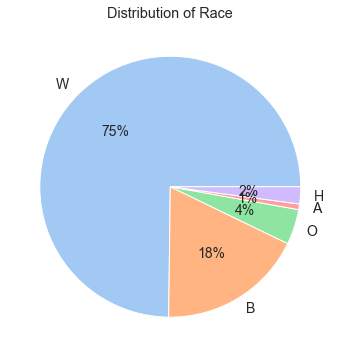

EDA for Race: 
 
count     71504
unique        5
top           W
freq      53488
Name: race, dtype: object 



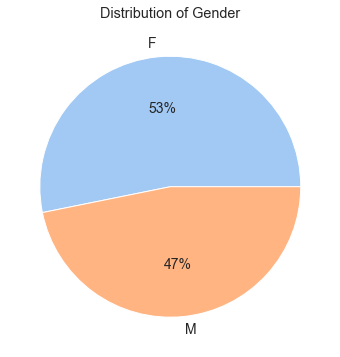

EDA for Gender: 
 
count     71504
unique        2
top           F
freq      38023
Name: gender, dtype: object 



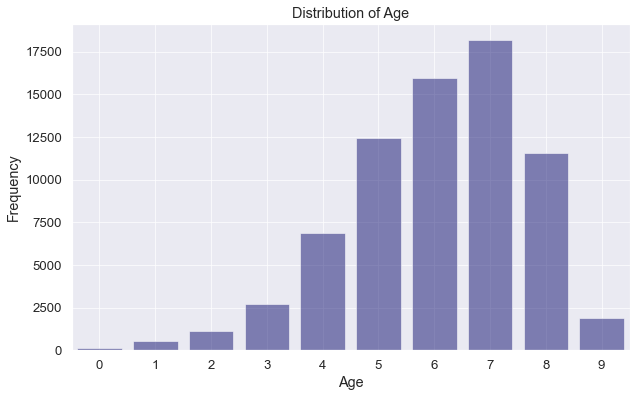

EDA for Age: 
 
count    71504.000000
mean         6.065129
std          1.597866
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: age, dtype: float64 



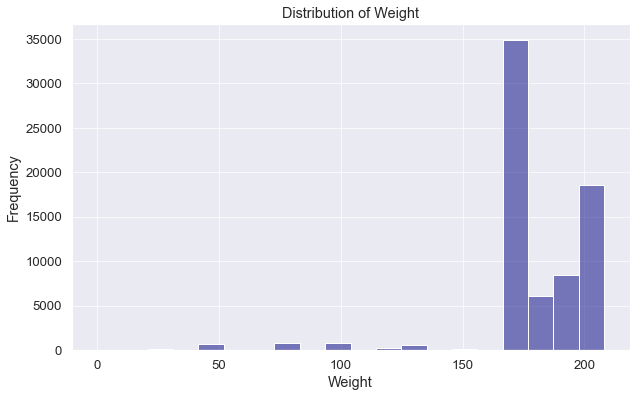

EDA for Weight: 
 
count    71504.000000
mean       177.590542
std         25.912680
min          0.000000
25%        166.500000
50%        176.400000
75%        201.200000
max        208.100000
Name: weight, dtype: float64 



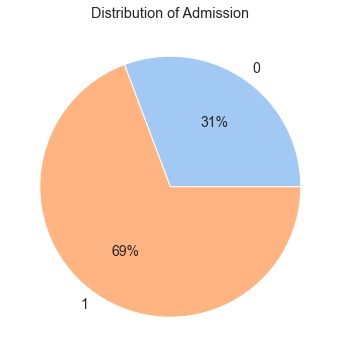

EDA for Admission: 
 
count    71504.000000
mean         0.692842
std          0.461319
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: admission, dtype: float64 



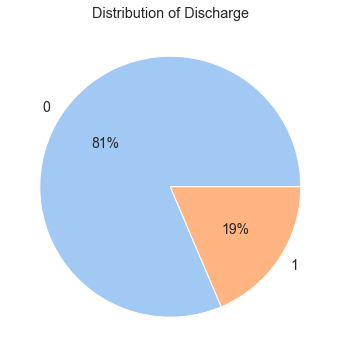

EDA for Discharge: 
 
count    71504.000000
mean         0.186115
std          0.389203
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: discharge, dtype: float64 



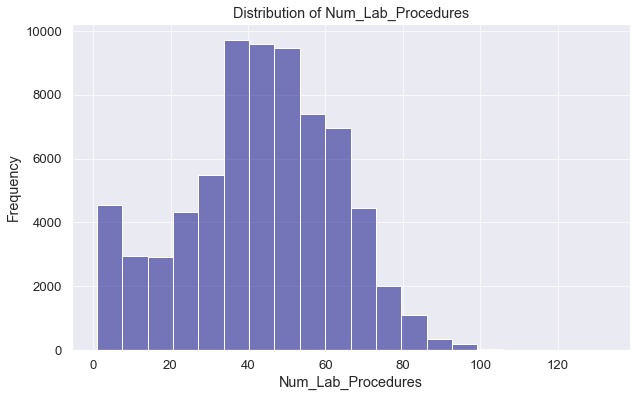

EDA for Num_Lab_Procedures: 
 
count    71504.000000
mean        43.076961
std         19.952208
min          1.000000
25%         31.000000
50%         44.000000
75%         57.000000
max        132.000000
Name: num_lab_procedures, dtype: float64 



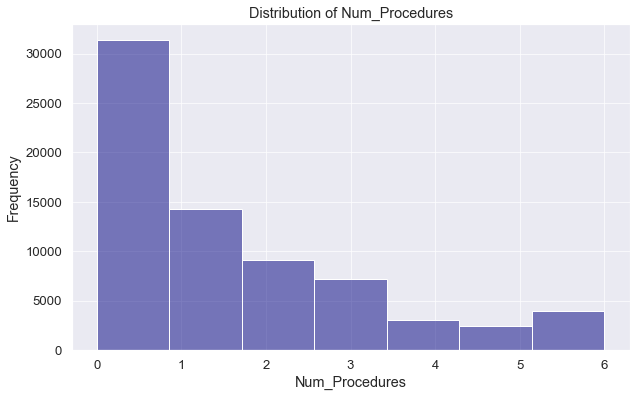

EDA for Num_Procedures: 
 
count    71504.000000
mean         1.430619
std          1.759937
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: num_procedures, dtype: float64 



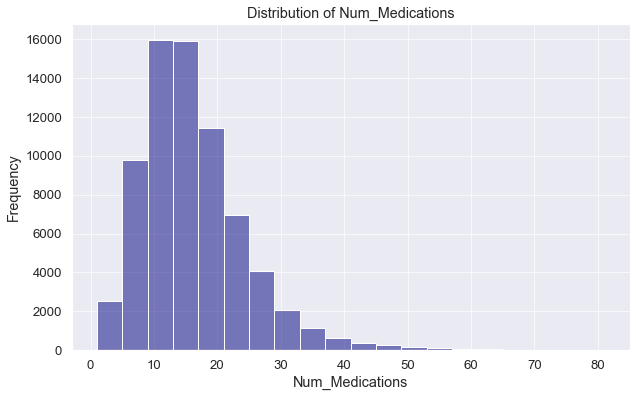

EDA for Num_Medications: 
 
count    71504.000000
mean        15.705121
std          8.311653
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max         81.000000
Name: num_medications, dtype: float64 



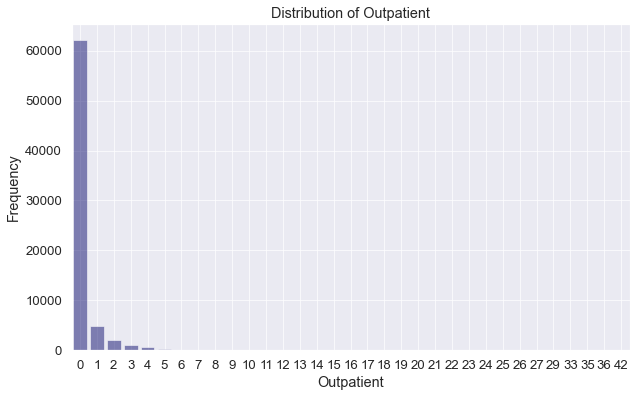

EDA for Outpatient: 
 
count    71504.000000
mean         0.280124
std          1.069054
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: outpatient, dtype: float64 



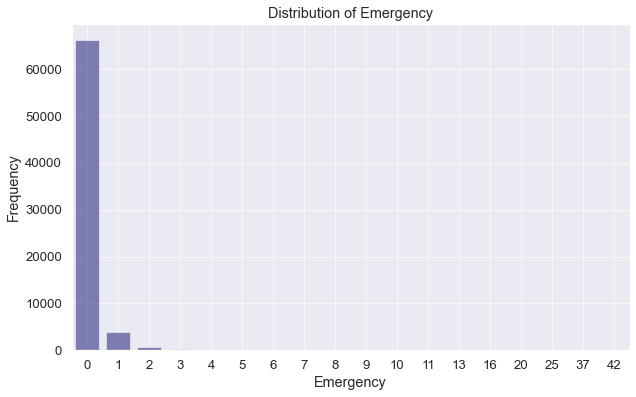

EDA for Emergency: 
 
count    71504.000000
mean         0.103547
std          0.509223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: emergency, dtype: float64 



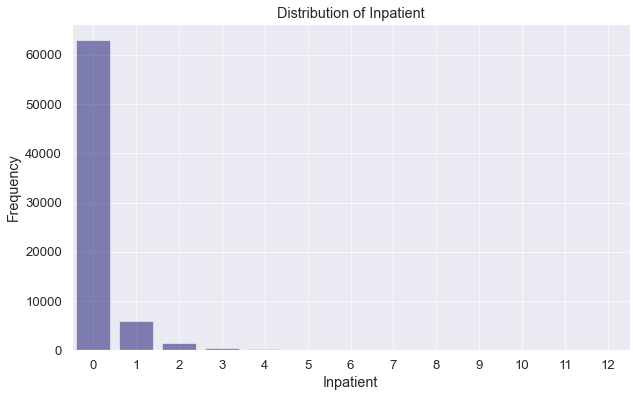

EDA for Inpatient: 
 
count    71504.000000
mean         0.177808
std          0.603744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: inpatient, dtype: float64 



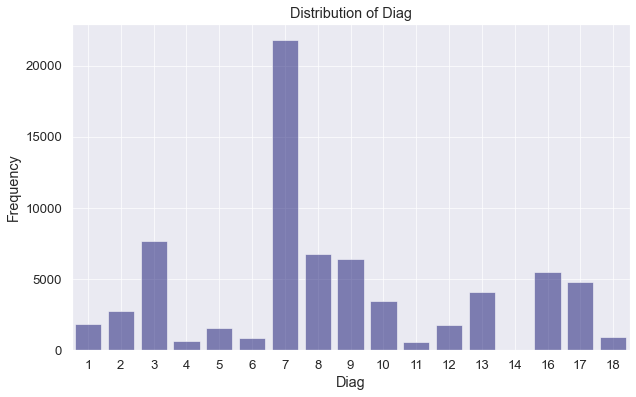

EDA for Diag: 
 
count    71504.000000
mean         8.573464
std          4.421023
min          1.000000
25%          7.000000
50%          7.000000
75%         10.000000
max         18.000000
Name: diag, dtype: float64 



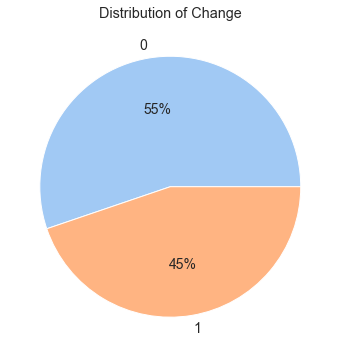

EDA for Change: 
 
count    71504.000000
mean         0.447765
std          0.497268
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: change, dtype: float64 



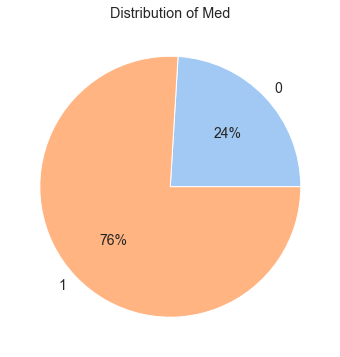

EDA for Med: 
 
count    71504.000000
mean         0.759524
std          0.427376
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: med, dtype: float64 



In [57]:
columns = df.columns

for column in columns:
    if column in ["race", "change", "med", "gender", "admission", "discharge"]:
        labels = df[column].unique()
        data = [df[column][df[column] == label].count() for label in labels] 
        ## Count the number of specific label in the column.
        
        colors = sns.color_palette('pastel')[0:df[column].nunique()]
        
        plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%', textprops={'fontsize': 14})
        plt.title(f"Distribution of {column.title()}")
        plt.show()
        print(f"EDA for {column.title()}: \n", f"\n{df[column].describe()} \n")
    
    elif column in ["weight", "num_lab_procedures", "num_procedures", "num_medications"]:
        bins = lambda column: 20 if df[column].nunique() > 20 else df[column].nunique()
        ## Set the bin number to 20 if there are more than 20 unique values in the column.
        ## Otherwise set the bin number to equal the number of unique values in the column.

        sns.histplot(data = df[column], 
                     bins = bins(column), 
                     color = "navy",
                     alpha = 0.5)
        
        plt.grid(alpha = 0.7)
        plt.xlabel(f"{column.title()}")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {column.title()}")
        plt.show()
        print(f"EDA for {column.title()}: \n", f"\n{df[column].describe()} \n")
    
    else:
        sns.countplot(x = df[column],  
                      color = "navy",
                      alpha = 0.5)
        plt.grid(alpha = 0.7)
        plt.xlabel(f"{column.title()}")
        plt.ylabel("Frequency")
        plt.title(f"Distribution of {column.title()}")
        plt.show()
        print(f"EDA for {column.title()}: \n", f"\n{df[column].describe()} \n")

Observations:
- The majority of the race is either Caucasian (white) or African American (black) accounting for 93% of the total data. The remaining 7% consists of Hispanic, Asian or other ethnic groups. Because the minority ethnic groups (Hispanic, Asian and others) are so underrepresented in the data, it is perhaps better to combine these groups as a single minority group called "Others".
- The gender distribution is roughly even, with slightly more females (53%) than males (47%).
- The majority of the patients in the data are age 50 or older.
- Most of the patients weight more than 160 pounds.
- Around 70% of the patients came to the hospital as an emergency, but only around 20% of the patients left the hospital in a serious condition (either deceased or long-term hospitalisation).
- An overwhelming majority of the patients never had an outpatient visit (any service you receive without being admitted to a hospital or for a stay shorter than 24 hours), inpatient visit (requiring overnight hospitalisation) or an emergency visit in the year preceding to the hospital visit. 
- The most common diagnosis was diseases of the circulatory system (including hypertensive diseases and cerebrovascular diseases), followed by endocrine, nutritional and metabolic diseases (including complications due to diabetes).
- 55% of the patients had their diabetes medicine changed at the time of hospital visit as part of the initial diagnosis.
- Only a quarter of the patients were not prescribed diabetes medicine prior to the hospital visit.

## 4. Feature Engineering

We have 11 features and 1 target variable, which is discharge disposition.
We will first split the main dataframe into X (features) and y (target) dataframes.
Then, we will now modify those 11 features to make the data structure more suitable for machine learning.

### 4.1. Creating X (features) and y (target) dataframes

In [58]:
df_sample = df.sample(5000, random_state = 1)
df_sample

,race,gender,age,weight,admission,discharge,num_lab_procedures,num_procedures,num_medications,outpatient,emergency,inpatient,diag,change,med
9144,B,M,7,193.4,1,0,54,0,17,0,0,0,3,1,1
36755,W,M,8,100.0,1,1,70,0,4,0,0,0,7,0,0
43587,W,M,6,201.2,1,0,57,1,19,0,0,1,8,0,1
36754,W,F,6,166.5,1,0,11,1,10,2,0,0,13,0,0
29358,O,F,3,167.6,1,0,57,0,11,0,0,0,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97631,W,M,5,202.5,1,0,62,0,20,0,0,0,16,0,1
12512,W,M,8,177.5,0,0,22,0,25,2,1,0,16,1,1
24183,W,M,4,206.9,1,0,51,3,20,0,0,0,13,0,1
26643,W,M,7,193.4,0,1,10,0,19,0,0,0,8,0,0


In [59]:
df_sample.discharge.value_counts()

0    4051
1     949
Name: discharge, dtype: int64

In [60]:
y = df_sample.discharge

X = df_sample.loc[:, df.columns != "discharge"]

In [61]:
X

,race,gender,age,weight,admission,num_lab_procedures,num_procedures,num_medications,outpatient,emergency,inpatient,diag,change,med
9144,B,M,7,193.4,1,54,0,17,0,0,0,3,1,1
36755,W,M,8,100.0,1,70,0,4,0,0,0,7,0,0
43587,W,M,6,201.2,1,57,1,19,0,0,1,8,0,1
36754,W,F,6,166.5,1,11,1,10,2,0,0,13,0,0
29358,O,F,3,167.6,1,57,0,11,0,0,0,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97631,W,M,5,202.5,1,62,0,20,0,0,0,16,0,1
12512,W,M,8,177.5,0,22,0,25,2,1,0,16,1,1
24183,W,M,4,206.9,1,51,3,20,0,0,0,13,0,1
26643,W,M,7,193.4,0,10,0,19,0,0,0,8,0,0


### 4.1 Change Categorical Data in String Format to Numerics

We will first replace Hispanic, Asian and Other ethnic groups into a single class called "Other", and change the current data which is in string format into numerics (i.e. 0, 1, and 2).

In [62]:
X.race = X.race.replace({"A": "O",
                         "H": "O"}) 

In [63]:
rle = LabelEncoder()
race_labels = rle.fit_transform(X['race'])
race_mappings = {index: label for index, label in 
                  enumerate(rle.classes_)}
race_mappings

{0: 'B', 1: 'O', 2: 'W'}

In [64]:
X.race = race_labels

### 4.2 Create A New Dataframe with Dummy Variables for Nominal Categorical Data (One Hot Encoding)

In [65]:
X_dummies = pd.get_dummies(data = X, columns = ['race', 'gender', "admission", "diag", "change", "med"], 
                                     prefix = ['race', 'gender', "admission", "diag", "change", "med"] )

X_dummies.head() ## We will use X_dummies for machine learning, and df for EDA.

,age,weight,num_lab_procedures,num_procedures,num_medications,outpatient,emergency,inpatient,race_0,race_1,...,diag_12,diag_13,diag_14,diag_16,diag_17,diag_18,change_0,change_1,med_0,med_1
9144,7,193.4,54,0,17,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
36755,8,100.0,70,0,4,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
43587,6,201.2,57,1,19,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
36754,6,166.5,11,1,10,2,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
29358,3,167.6,57,0,11,0,0,0,0,1,...,0,0,0,0,1,0,1,0,1,0


### 4.3 Label Encoding for Ordinal Categorical Data

This has already been done during data cleaning. All categorical data have been changed to numerical values starting from 0.

### 4.4 Standardise numerical data

Here, we need to standardise the weight column, which is the only numerical column within the dataset.

This will be done when we split the data into training and test sets (see Section 5.0)

### 4.5 Feature Selections

We will first examine the correlation between the features and the target.

In [66]:
df_corr = pd.concat([X, y], axis = 1)

df_corr.gender = df_corr.gender.replace({"F": 1,
                                         "M": 0}) 
## Converting female and male into numerical values in a temporary dataframe to do correlation analysis

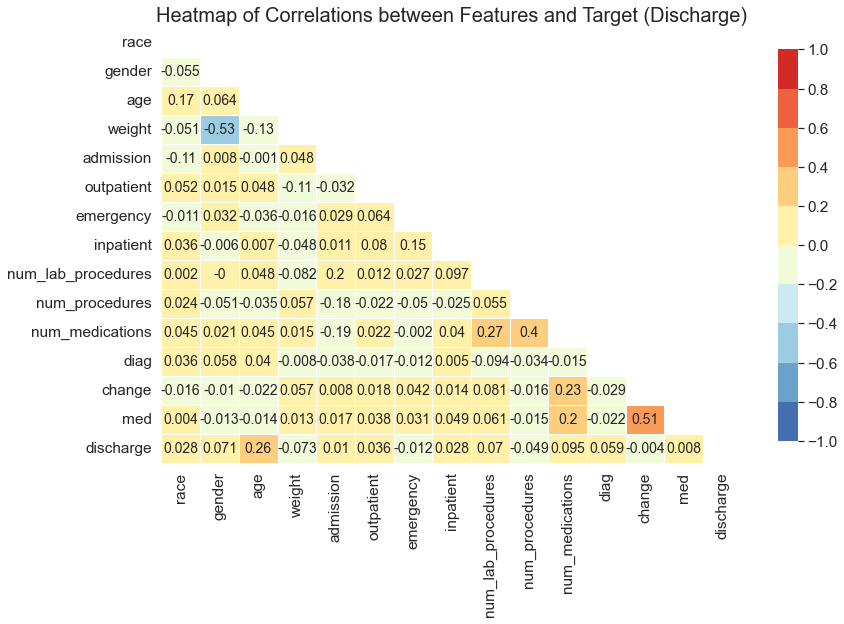

In [67]:
col_names = ["race", "gender", "age", "weight", "admission", "outpatient", "emergency", "inpatient", 
             "num_lab_procedures", "num_procedures", "num_medications", "diag", "change", "med", "discharge"]

mask = np.zeros_like(df_corr[col_names].corr())
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(13,8))

    my_colors = sns.color_palette("RdYlBu_r", 10)
    my_cmap = ListedColormap(my_colors)
    bounds = np.linspace(-1,1,11)
    my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

    plt.title("Heatmap of Correlations between Features and Target (Discharge)", fontsize = 20)
    sns.heatmap(round(df_corr[col_names].corr(), 3),
                cmap=my_cmap,
                norm=my_norm,
                annot=True,
                annot_kws=dict(fontsize = 14),
                cbar_kws=dict(ticks=bounds, shrink=0.9, location = "right"),
                linewidths=.5,
                mask = mask)

plt.show()


It appears that age has the strongest correlation to discharge status (0.28). Other features all have very weak (negligible) correlation.

For now, I will include all features for machine learning.

## 5.0 Machine Learning

Because this is a classification problem, we will focus on using logistic regression, support vector machine (SVM) and naive Bayesian models.

I will apply 65:15:20 train-validation-test split.

### 5.1 Create a User-defined Function to Automate Building the Model, Feature Select, and Grid Search.

In [68]:
## A function to choose the model depending on the user input

def get_model(X, y, model = "log", split = 0.2, rs = 1, cv = 5, smote=True): 
    ## Choose between "log", "svm" and "nb" models. The default is set to "log".
    ## Choose the split ratio. The default is set to 0.2 (80:20 split between train and test data)
    ## Choose the random state. The default is set to 1.
    ## Choose the number of folds for cross validation. The default is set to 5.
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=rs)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=split, random_state=rs)
    
    
    ## Standardise the dataset
    scaler= StandardScaler()
    columns = ["age", "weight", "num_lab_procedures", "num_procedures", "num_medications"]
    
    for column in columns:
        train_value = np.asarray(X_train[column]).reshape(-1, 1)
        val_value = np.asarray(X_val[column]).reshape(-1, 1)
        test_value = np.asarray(X_test[column]).reshape(-1, 1)
        # standardization 
        X_train[column] = scaler.fit_transform(train_value)
        X_val[column] = scaler.transform(val_value)
        X_test[column] = scaler.transform(test_value)

        
    if smote == True:
        sm = SMOTE(random_state=rs)
        X_res, y_res = sm.fit_resample(X_train, y_train)
    else:
        X_res = X_train
        y_res = y_train
    
    ## Set the classification model object based on the user input & set up grid search parameters.
    if model == "log":
        model = LogisticRegression(solver = "liblinear", max_iter = 10000)
        params = {'penalty': ['l1','l2'], 
                  'C': [2 ** i for i in np.linspace(-5,15, num=11)]}
    
    elif model == "svm":
        model = svm.SVC(probability = True)
        params = {'C': [2 ** i for i in np.linspace(0,8, num=4)],
                  'gamma': [2 ** i for i in np.linspace(-13,-1, num=5)],
                  'kernel': ['rbf','sigmoid','linear']}
    
    else:
        model = GaussianNB()
        params = {'var_smoothing': np.logspace(0,-9, num=10)}

        
    ## Gridsearch
    grid = GridSearchCV(model, params, scoring=['accuracy', 'f1', 'roc_auc'], 
                        return_train_score=True, n_jobs=4, refit='accuracy')
    grid.fit(X_res, y_res)

    print("Best estimator: ", grid.best_estimator_)
    print("Best parameters: ", grid.best_params_)
    print("Best mean cross-validation score: ", round(grid.best_score_, 3)) 
    ## Mean cross-validated score of the best_estimator

    return grid, X_val, y_val, X_test, y_test


In [69]:
## Predict Function

def predict(model, X_test, y_test):
    
    ## Prediction using the Best Model
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[::,1]
    acc = accuracy_score(y_test, pred)
 
    confusion_matrix = metrics.confusion_matrix(y_test, pred)
    cm_df = pd.DataFrame(confusion_matrix)
    cm_df.index = ['is_discharged', 'is_hospitalised']
    cm_df.columns=['predicted_discharge','predicted_hospitalise']
    cm_df = cm_df.astype("float64")

    fpr, tpr, thresholds = metrics.roc_curve(y_test,  prob)
    print("Accuracy Score: ", round(acc, 3))
        
    auc = metrics.roc_auc_score(y_test, prob)

    ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=["D", "H"])
    plt.grid(alpha = 0)
    plt.show()

    print(f"Classification Report (0 = Discharge, 1 = Hospitalisation): \n", classification_report(y_test,pred))

    return fpr, tpr, auc

### 5.2 Create and Fit the Model Based on Training Data and Evaluate Performance Using Validation Data

#### 5.2.1 Logistic Regression Model

Gridsearch criteria:
1. 'penalty': l1, l2 
2. 'C': $2^{i}$ where i = -5 to 15

In [70]:
log, X_val, y_val, X_test, y_test = get_model(X_dummies, y)

Best estimator:  LogisticRegression(C=8.0, max_iter=10000, penalty='l1', solver='liblinear')
Best parameters:  {'C': 8.0, 'penalty': 'l1'}
Best mean cross-validation score:  0.819


Accuracy Score:  0.786


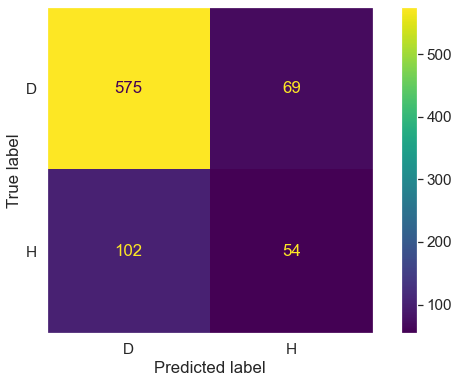

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       644
           1       0.44      0.35      0.39       156

    accuracy                           0.79       800
   macro avg       0.64      0.62      0.63       800
weighted avg       0.77      0.79      0.78       800



In [71]:
fpr_log, tpr_log, auc_log = predict(log, X_val, y_val)

Analysis:
- The best hyperparameters chosen for the logistic regression model are: C=8.0 and penalty='l1' using 'liblinear' solver.
- The accuracy score on validation dataset is 0.786, but looking at the confusion matrix, the model misses out on predicting the true hospitalisation cases, as indicated by low precision and recall scores.
- The scores for training and validation datasets are 0.819 and 0.786, respectively, which indicates that there is no overfitting.
    

#### 5.2.2 Support Vector Machine

Initial run of SVM did not predict any hospitalisation cases due to imbalance issue, so I have switched to using SMOTE.

Gridsearch criteria:
1. 'C': $2^{i}$ for i = 0 to 8
2. 'gamma': $2^{i}$ for i = -13 to -1
3. 'kernel': rbf, sigmoid, linear 

In [72]:
%%time
svm, X_val, y_val, X_test, y_test = get_model(X_dummies, y, model = "svm")

Best estimator:  SVC(C=6.3496042078727974, gamma=0.5, probability=True)
Best parameters:  {'C': 6.3496042078727974, 'gamma': 0.5, 'kernel': 'rbf'}
Best mean cross-validation score:  0.888
CPU times: user 10.5 s, sys: 331 ms, total: 10.8 s
Wall time: 12min 5s


Accuracy Score:  0.755


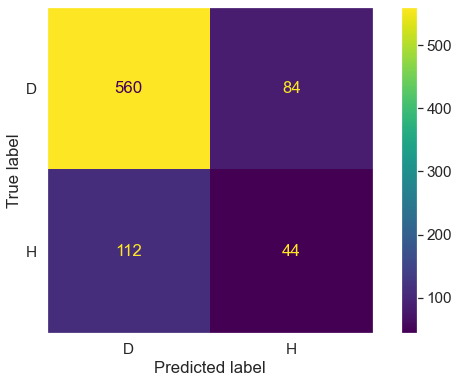

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       644
           1       0.34      0.28      0.31       156

    accuracy                           0.76       800
   macro avg       0.59      0.58      0.58       800
weighted avg       0.74      0.76      0.75       800



In [73]:
fpr_svm, tpr_svm, auc_svm = predict(svm, X_val, y_val)

Analysis:
- The best hyperparameters chosen for the SVM model are: 'C'=  6.35, 'gamma' =  0.5 and 'kernel' = 'rbf'.
- The accuracy score on validation dataset is 0.755, but again, looking at the confusion matrix, the model misses out on predicting the true hospitalisation cases, as indicated by low precision and recall scores.
- SVM model has performed worse than the logistic regression model, in every metrics.
- The scores for training and validation datasets are 0.888 and 0.755, respectively, which indicates that there may be slight overfitting or underfitting.

#### 5.2.3 Naive Bayesian (Gaussian)

In [74]:
nb, X_val, y_val, X_test, y_test = get_model(X_dummies, y, model = "nb")

Best estimator:  GaussianNB(var_smoothing=0.01)
Best parameters:  {'var_smoothing': 0.01}
Best mean cross-validation score:  0.684


Accuracy Score:  0.551


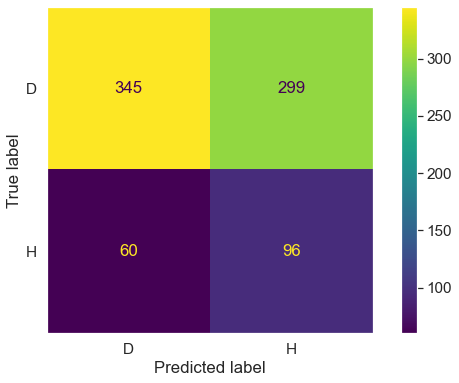

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.85      0.54      0.66       644
           1       0.24      0.62      0.35       156

    accuracy                           0.55       800
   macro avg       0.55      0.58      0.50       800
weighted avg       0.73      0.55      0.60       800



In [75]:
fpr_nb, tpr_nb, auc_nb = predict(nb, X_val, y_val)

Analysis:
- The best hyperparameter chosen for the Gaussian NB model is: 'var_smoothing' = 0.01.
- The accuracy score on validation dataset is 0.551, which is the worst of the three models.
- From the confusion matrix, we see that the NB model does better at predicting true hospitalisation cases, but badly misclassifies true discharge cases. This results in higher precision and recall scores, but lower accuracy.
- SVM model has performed worse than the logistic regression model, in every metrics.
- The scores for training and validation datasets are 0.888 and 0.755, respectively, which indicates that there may be slight overfitting or underfitting.

### 5.3 Evaluate the Performance of Each Model Based on ROC-AUC Scores

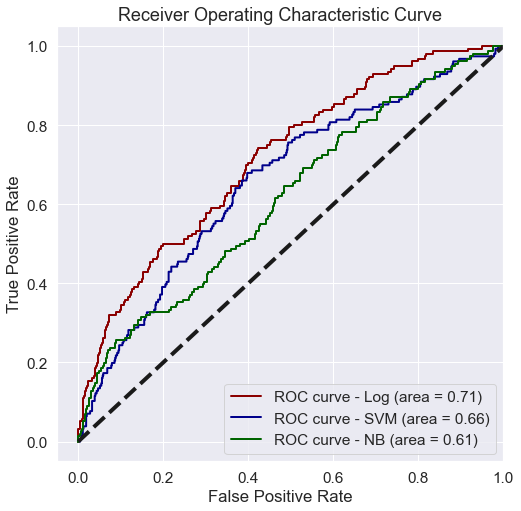

In [76]:
## ROC, AUC, and test scores...
plt.figure(figsize=[8,8])
lw = 2
plt.plot(fpr_log, tpr_log, color='darkred', lw = lw, label = 'ROC curve - Log (area = %0.2f)' % auc_log)
plt.plot(fpr_svm, tpr_svm, color='darkblue', lw = lw, label = 'ROC curve - SVM (area = %0.2f)' % auc_svm)
plt.plot(fpr_nb, tpr_nb, color='darkgreen', lw = lw, label = 'ROC curve - NB (area = %0.2f)' % auc_nb)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize = 18)
plt.legend(loc = "lower right")
plt.show()


Analysis:
- The logistic regression model performed best with AUC of 0.71, followed by SVM with AUC of 0.66, and NB with AUC of 0.61.
- Given its relatively low AUC score, there is certainly room for improvement.

### 5.4 Optimise the Best Classification Model (Logistic Regression Model)

Here, we will optimise logistic regression, first by increasing the size of dataset, and trying out different thresholds.

We will also try out different Naive Bayesian models, which was close to Logistic Regression model in term of AUC score, using the whole dataset

#### 5.4.1 Prepare new datasets

In [77]:
y = df.discharge
X = df.loc[:, df.columns != "discharge"]

X.race = X.race.replace({"A": "O",
                         "H": "O"}) 

rle = LabelEncoder()
race_labels = rle.fit_transform(X['race'])
race_mappings = {index: label for index, label in enumerate(rle.classes_)}

X.race = race_labels

X_dummies = pd.get_dummies(data = X, columns = ['race', 'gender', "admission", "diag", "change", "med"], 
                                     prefix = ['race', 'gender', "admission", "diag", "change", "med"] )


#### 5.4.2 Create and Fit the Model using Training Data, and Evaluate

In [78]:
log_new, X_val, y_val, X_test, y_test = get_model(X_dummies, y, smote=False)

Best estimator:  LogisticRegression(C=0.03125, max_iter=10000, penalty='l1', solver='liblinear')
Best parameters:  {'C': 0.03125, 'penalty': 'l1'}
Best mean cross-validation score:  0.824


Accuracy Score:  0.82


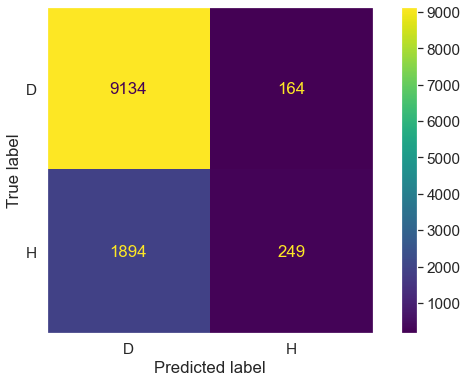

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.83      0.98      0.90      9298
           1       0.60      0.12      0.19      2143

    accuracy                           0.82     11441
   macro avg       0.72      0.55      0.55     11441
weighted avg       0.79      0.82      0.77     11441



In [79]:
fpr_log_new, tpr_log_new, auc_log_new = predict(log_new, X_val, y_val)

Analysis:
- Compared to the original logistic model, this new version has improved in terms of accuracy, going from 0.786 to 0.82.
- However, it still suffers from low precion and recall scores. The model's ability to predict true hospitalisation cases, especially seems to have worsened as indicated by very low recall score. This is probably due to imbalance we introduced when we increased the size of training dataset to include all available observations.

#### 5.4.3 Finding the Optimal Threshold

We can adjust the threshold so that the model can better predict true hospitalisation cases, but this comes at a cost of misclassifying true discharge cases. We will find the optimal threshold using g-means.

Best Threshold=0.193533, G-Mean=0.702


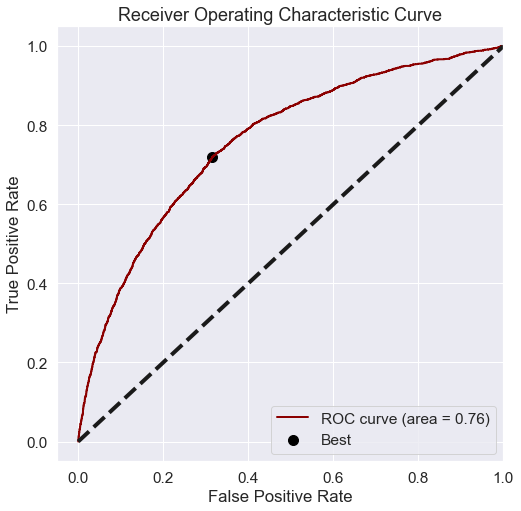

In [80]:
plt.figure(figsize=[8,8])
# predict probabilities
yhat = log_new.predict_proba(X_val)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_val, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
lw = 2
plt.plot(fpr_log_new, tpr_log_new, color='darkred', lw = lw, label = 'ROC curve (area = %0.2f)' % auc_log_new)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best', s = 100)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize = 18)
plt.legend(loc = "lower right")
plt.show()

best_threshold = thresholds[ix]

The optimal threshold is 0.194.

Threshold:  0.194
Accuracy Score:  0.691


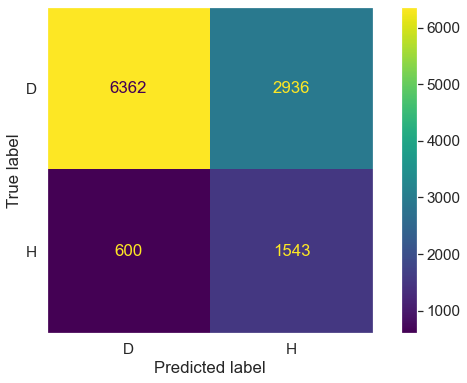

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.91      0.68      0.78      9298
           1       0.34      0.72      0.47      2143

    accuracy                           0.69     11441
   macro avg       0.63      0.70      0.62     11441
weighted avg       0.81      0.69      0.72     11441



In [81]:

y_pred = (log_new.predict_proba(X_val)[:, 1] > best_threshold).astype('float')
acc = accuracy_score(y_val, y_pred)

print("Threshold: ", round(best_threshold, 3))
print("Accuracy Score: ", round(acc, 3))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["D", "H"])
plt.grid(alpha = 0)
plt.show()   

print(f"Classification Report (0 = Discharge, 1 = Hospitalisation): \n", classification_report(y_val, y_pred))

We have significantly improved the model's capability to predict true hospitalisation, at the cost of misclassifying some of the true discharge cases.

What we prefer at this point comes down to the business domain knowledge:
- What is the cost of misclassifying healthy patients as risk patients (which leads to unnecessary tests and hospital care), versus:
-  What is the cost of misclassifying risk patients as healthy (which leads to missed opportunity for the patient to receive timely care, which could ultimately save the patient's life)

How do you choose the threshold on the ROC Curve that results in the best balance between the true positive rate and the false positive rate?
 
 There are many ways we could locate the threshold with the optimal balance between false positive and true positive rates.

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.

Sensitivity = TruePositive / (TruePositive + FalseNegative)
Specificity = TrueNegative / (FalsePositive + TrueNegative)
Where:

Sensitivity = True Positive Rate
Specificity = 1 – False Positive Rate
The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

G-Mean = sqrt(Sensitivity * Specificity)
One approach would be to test the model with each threshold returned from the call roc_auc_score() and select the threshold with the largest G-Mean value.

Given that we have already calculated the Sensitivity (TPR) and the complement to the Specificity when we calculated the ROC Curve, we can calculate the G-Mean for each threshold directly.

(from Machine Learning Mastery - https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/)

#### 5.4.4 Different Naive Bayesian Models

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

## Standardise the dataset
scaler= StandardScaler()
columns = ["age", "weight", "num_lab_procedures", "num_procedures", "num_medications"]

for column in columns:
    train_value = np.asarray(X_train[column]).reshape(-1, 1)
    val_value = np.asarray(X_val[column]).reshape(-1, 1)
    test_value = np.asarray(X_test[column]).reshape(-1, 1)
    # standardization 
    X_train[column] = scaler.fit_transform(train_value)
    X_val[column] = scaler.transform(val_value)
    X_test[column] = scaler.transform(test_value)

    
## GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

y_pred_gauss = clf.predict(X_val)
print("Score: ", accuracy_score(y_val, y_pred_gauss))
print(f"Confusion Matrix: \n", metrics.confusion_matrix(y_val,y_pred_gauss))
print(f"Classification Report: \n", classification_report(y_val,y_pred_gauss))

## BernoulliNB

clf = BernoulliNB()
clf.fit(X_train, y_train)

y_pred_bern = clf.predict(X_val)
print("Score: ", accuracy_score(y_val, y_pred_bern))
print(f"Confusion Matrix: \n", metrics.confusion_matrix(y_val,y_pred_bern))
print(f"Classification Report: \n", classification_report(y_val,y_pred_bern))



Score:  0.5689188008041255
Confusion Matrix: 
 [[4915 4383]
 [ 549 1594]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.53      0.67      9298
           1       0.27      0.74      0.39      2143

    accuracy                           0.57     11441
   macro avg       0.58      0.64      0.53     11441
weighted avg       0.78      0.57      0.61     11441

Score:  0.8071846866532646
Confusion Matrix: 
 [[8743  555]
 [1651  492]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      9298
           1       0.47      0.23      0.31      2143

    accuracy                           0.81     11441
   macro avg       0.66      0.58      0.60     11441
weighted avg       0.77      0.81      0.78     11441



Bernoulli NB model improved in terms of accuracy, but at the cost of recall score (0.23 compared to 0.74 for Gaussian NB model).
Both models did not offer any significant advantage over the chosen logistic regression model.

## 6.0 Evaluate the Final Model Using Test Data

The best model is log_new using threshold of 0.194

Threshold:  0.194
Accuracy Score:  0.686


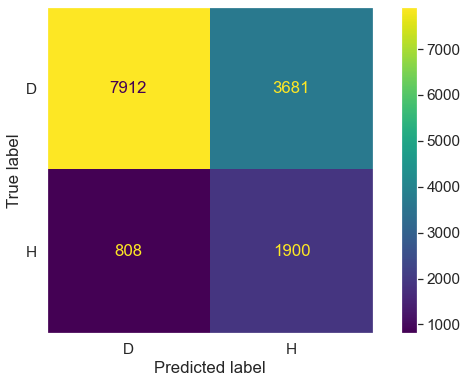

Classification Report (0 = Discharge, 1 = Hospitalisation): 
               precision    recall  f1-score   support

           0       0.91      0.68      0.78     11593
           1       0.34      0.70      0.46      2708

    accuracy                           0.69     14301
   macro avg       0.62      0.69      0.62     14301
weighted avg       0.80      0.69      0.72     14301



In [83]:
y_pred = (log_new.predict_proba(X_test)[:, 1] > best_threshold).astype('float')
acc = accuracy_score(y_test, y_pred)

print("Threshold: ", round(best_threshold, 3))
print("Accuracy Score: ", round(acc, 3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["D", "H"])
plt.grid(alpha = 0)
plt.show()   

print(f"Classification Report (0 = Discharge, 1 = Hospitalisation): \n", classification_report(y_test, y_pred))

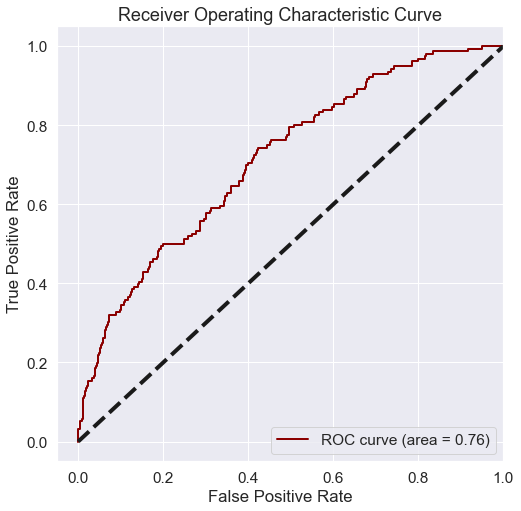

In [84]:
plt.figure(figsize=[8,8])
lw = 2
plt.plot(fpr_log, tpr_log, color='darkred', lw = lw, label = 'ROC curve (area = %0.2f)' % auc_log_new)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize = 18)
plt.legend(loc = "lower right")
plt.show()

Analysis:
- The test accuracy score was 0.686 and AUC was 0.76, which is close to the validation scores (so there is no overfitting).
- For the test case, the data predicted correctly classified around 70% of both true discharge and true hospitalisation cases.


## 7.0 Conclusion

As a proof of concept model, the logistic model has performed reasonably well in classifying discharge and hospitalisation cases.
It is recommended to gather more relevant (i.e. higher correlated data) patient data, such as the patients' vitals (blood pressure, heart rate, etc) to improve the model's accuracy.
Future modelling should focus on improving the recall score.

In [85]:
coeff = log_new.best_estimator_.coef_[0]
intercept = log_new.best_estimator_.intercept_[0]

In [86]:

coeff_zip = list(zip(X_train.columns, coeff))

for col in coeff_zip:
    print('{:<10s} {:+.02f}'.format(col[0], col[1]))
print(f"Intercept: {round(intercept, 3)}")


age        +0.96
weight     +0.00
num_lab_procedures +0.16
num_procedures -0.15
num_medications +0.29
outpatient +0.02
emergency  +0.00
inpatient  +0.04
race_0     +0.00
race_1     -0.00
race_2     -0.07
gender_F   +0.00
gender_M   -0.25
admission_0 -0.10
admission_1 +0.00
diag_1     +0.28
diag_2     -0.13
diag_3     +0.00
diag_4     +0.00
diag_5     +0.02
diag_6     +0.00
diag_7     -0.54
diag_8     -0.13
diag_9     -0.60
diag_10    +0.00
diag_11    +0.00
diag_12    +0.00
diag_13    +0.30
diag_14    +0.00
diag_16    -0.67
diag_17    +0.51
diag_18    -0.30
change_0   +0.00
change_1   -0.02
med_0      +0.00
med_1      -0.21
Intercept: -1.226


In [87]:
sorted = sorted(coeff_zip, key=lambda x: x[1], reverse=True)
print(sorted[:5])
print(sorted[-5:])

[('age', 0.9553680553972957), ('diag_17', 0.5083392988878263), ('diag_13', 0.2997767074407829), ('num_medications', 0.28804054033035265), ('diag_1', 0.2798413120033523)]
[('gender_M', -0.24509840619319218), ('diag_18', -0.2968079609546735), ('diag_7', -0.5446345007639664), ('diag_9', -0.5990087572162075), ('diag_16', -0.6703420854406384)]


## APPENDIX

### Learning Curve

/Users/chang-joonlee/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


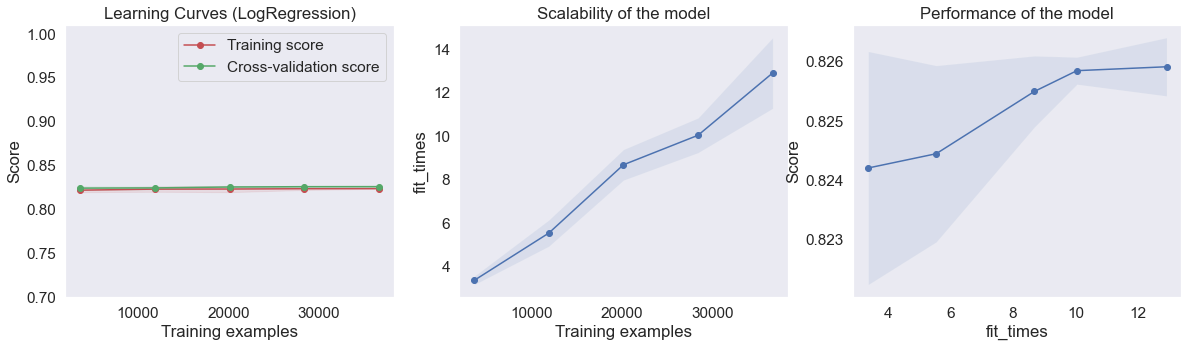

In [88]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = r"Learning Curves (LogRegression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
estimator = log_new
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4, scoring='accuracy')

plt.show()

The model does not significantly improve in terms of score as you increase the number of training datasets.
It is probably better to use less data to save computational cost.

In [89]:
# !pip install mlxtend

In [90]:
## Tried to do backward feature elimination but decided not to because it took too long.

# from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# model = log_new

# sfs1 = sfs(model, k_features=4, forward=False, verbose=1, scoring='roc_auc')
# sfs1 = sfs1.fit(X_train, y_train)

# feat_names = list(sfs1.k_feature_names_)
# print(feat_names)